In [1]:
import bempp.api
import numpy as np

bempp.api.global_parameters.hmat.eps = 1E-5

In [2]:
centers = [0]
number_of_scatterers = len(centers)

#GRID = bempp.api.shapes.sphere(r=1.0, origin=(0, 0, 0), h=0.25)
#GRID = bempp.api.import_grid('hex-plate-e-0.4.msh')
GRID = bempp.api.import_grid('hex_AR0pt1_e0pt05.msh')

In [3]:
vacuum_permittivity = 8.854187817E-12

er = (1.775+0.0027j)**2  
mr = 1.0


rel_permittivities = number_of_scatterers * [2.1]
rel_permeabilities = number_of_scatterers * [1.0]

k0 = 5.
wavenumber = k0 * np.sqrt(er * mr)
print("The exterior wavenumber is: {0}".format(k0))
print("The interior wavenumber is: {0}".format(wavenumber))

The exterior wavenumber is: 5.0
The interior wavenumber is: (8.875+0.013500000000000002j)


In [4]:
theta = np.pi / 2 # Incident wave travelling at a 90 degree angle
direction = np.array([np.cos(theta), np.sin(theta), 0])
polarization = np.array([1.0, 0.0, 0.0])

def plane_wave(point):
    return polarization * np.exp(1j * k0 * np.dot(point, direction))

def scaled_plane_wave(point):
    return np.sqrt(vacuum_permittivity) * plane_wave(point)

def tangential_trace(point, n, domain_index, result):
    result[:] =  np.cross(scaled_plane_wave(point), n)

def scaled_plane_wave_curl(point):
    return np.cross(direction, polarization) * 1j * k0 * np.sqrt(vacuum_permittivity) * np.exp(1j * k0 * np.dot(point, direction))

def neumann_trace(point, n, domain_index, result):
    result[:] =  1./ (1j * k0) * np.cross(scaled_plane_wave_curl(point), n)

In [5]:
def rescale(A, d1, d2):
    """Rescale the 2x2 block operator matrix A"""
    
    A[0, 1] = A[0, 1] * (d2 / d1)
    A[1, 0] = A[1, 0] * (d1 / d2)
    
    return A

In [6]:
scaled_interior_operators = [rescale(bempp.api.operators.boundary.maxwell.multitrace_operator(
        GRID, wavenumber), np.sqrt(er), np.sqrt(mr))]

identity_operators = [bempp.api.operators.boundary.sparse.multitrace_identity(GRID, spaces='maxwell')]

exterior_operators = [bempp.api.operators.boundary.maxwell.multitrace_operator(GRID, k0)]

In [7]:
filter_operators = number_of_scatterers * [None]
transfer_operators = np.empty((number_of_scatterers, number_of_scatterers), dtype=np.object)

#The following will contain the left-hand side block operator
op = bempp.api.BlockedOperator(2 * number_of_scatterers, 2 * number_of_scatterers)
        
filter_operators[0] = .5 * identity_operators[0]- scaled_interior_operators[0]
element = scaled_interior_operators[0] + exterior_operators[0]
#Assign the 2x2 element to the block operator matrix.
op[0, 0] = element[0, 0]
op[0, 1] = element[0, 1]
op[1, 0] = element[1, 0]
op[1, 1] = element[1, 1]  

In [8]:
rhs = 2 * number_of_scatterers * [None]
incident_trace_data = number_of_scatterers * [None]

for i in range(number_of_scatterers):
    incident_trace_data[i] = (
        bempp.api.GridFunction(op.domain_spaces[2 * i], fun=tangential_trace, dual_space=op.dual_to_range_spaces[2 * i]),
        bempp.api.GridFunction(op.domain_spaces[2 * i + 1], fun=neumann_trace, 
                               dual_space=op.dual_to_range_spaces[2 * i + 1]))
    rhs[2 * i], rhs[2 * i + 1] = filter_operators[i] * incident_trace_data[i]

System solve via GMRES:

In [9]:
# With Calderon preconditioning:
sol, info, its = bempp.api.linalg.gmres(op * op, op * rhs, use_strong_form=True, return_iteration_count=True)
# With only mass-matrix preconditioning:
#sol, info, its = bempp.api.linalg.gmres(op, rhs, use_strong_form=True, return_iteration_count=True)
print("The iterative solver converged in {0} iterations.".format(its))

The iterative solver converged in 18 iterations.


In [10]:
interior_trace_data = number_of_scatterers * [None]

for i in range(number_of_scatterers):
    interior_trace_data[i] = [np.sqrt(rel_permittivities[i]) * incident_trace_data[i][0],
                              np.sqrt(rel_permeabilities[i]) * incident_trace_data[i][1]]
    for j in range(number_of_scatterers):
        if i != j:
            efield, mfield = -transfer_operators[i, j] * (sol[2 * j], sol[2 * j + 1])
        else:
            efield, mfield = sol[2 * j], sol[2 * j + 1]
        interior_trace_data[i][0] += np.sqrt(rel_permittivities[i]) * efield
        interior_trace_data[i][1] += np.sqrt(rel_permeabilities[i]) * mfield

If you want to plot the field in the z=0 plane, uncomment the section below.

In [11]:
# # Number of points in the x-direction
# nx = 101
# # Number of points in the y-direction
# ny = 101
# %matplotlib inline
# from matplotlib import path
# xmin, xmax, ymin, ymax = [-1.5, 1.5, -1.5, 1.5]
# plot_grid = np.mgrid[xmin:xmax:nx * 1j, ymin:ymax:ny * 1j]
# points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel(), 0. * np.ones(plot_grid[0].size)))
# points_plot = np.transpose(np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel())))

# x, y, z = points
# # For hexagon
# p = path.Path([(1,0),(0.5,0.866054),(-0.5,0.86602539),(-1,0),(-0.5,-0.8660254),(0.5,-0.8660254),(1,0)])
# inout = p.contains_points(points_plot)

# ext_indices = np.where(~inout)[0]
# int_indices = np.where(inout)[0]
# hey = np.logical_not(inout)

# # Set high quadrature order to improve accuracy near the scatterer's boundary
# bempp.api.global_parameters.quadrature.near.single_order = 15
# bempp.api.global_parameters.quadrature.medium.single_order = 15

# # Evaluate the field in the interior and exterior of the scatterer
# epot_int = bempp.api.operators.potential.maxwell.electric_field(interior_trace_data[0][1].space, points[:,int_indices], wavenumber)
# mpot_int = bempp.api.operators.potential.maxwell.magnetic_field(interior_trace_data[0][0].space, points[:,int_indices], wavenumber)
# epot_ext = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, points[:,ext_indices], k0)
# mpot_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, points[:,ext_indices], k0)

# exterior_values = -epot_ext * sol[1] - mpot_ext * sol[0]
# interior_values = (epot_int * interior_trace_data[0][1] + mpot_int * interior_trace_data[0][0])

# # First compute the scattered field
# scattered_field = np.empty((3, points.shape[1]), dtype='complex128')
# scattered_field[:, :] = np.nan
# scattered_field[:, ext_indices] = 1./np.sqrt(vacuum_permittivity) * exterior_values

# # Now compute the total field
# total_field = np.empty((3, points.shape[1]), dtype='complex128')

# for i in range(exterior_values.shape[1]):
#     total_field[:, ext_indices[i]] = scattered_field[:, ext_indices[i]] + plane_wave(points[:, ext_indices[i]])
    
# for i in range(number_of_scatterers):
#     # Add interior contributions
#     total_field[:, int_indices] = 1. / np.sqrt(rel_permittivities[i] * vacuum_permittivity) * interior_values[i]
    
# plot_total_field = np.real(total_field[0,:])
# total_image = plot_total_field.reshape(nx, ny).T

# %matplotlib inline
# # Plot the image
# from matplotlib import pyplot as plt
# import matplotlib.patches as patches
# fig = plt.figure(figsize = (10, 8))
# ax = fig.add_subplot(111)
# patch = patches.PathPatch(p, facecolor='none', lw=2)
# plt.imshow(total_image,extent=[-1.5,1.5,-1.5,1.5],cmap='bwr')
# ax.add_patch(patch)
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.colorbar()
# plt.title("Re($E_x$) for $z=0$")

Evalulating and plotting the field along the y-axis (x=0, z=0)

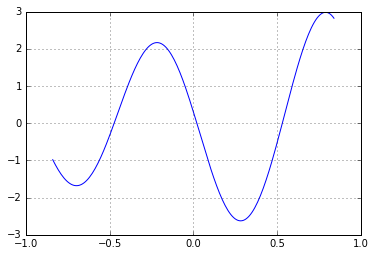

In [12]:
# Evaluate the field along y-axis
y_line = np.linspace(-0.84,0.84,200)
points_line = np.vstack([y_line * 0., y_line, y_line * 0.])

# Set high quadrature order to improve accuracy near the scatterer's boundary
bempp.api.global_parameters.quadrature.near.single_order = 15
bempp.api.global_parameters.quadrature.medium.single_order = 15

epot_int = bempp.api.operators.potential.maxwell.electric_field(interior_trace_data[0][1].space, points_line, wavenumber)
mpot_int = bempp.api.operators.potential.maxwell.magnetic_field(interior_trace_data[0][0].space, points_line, wavenumber)

res_line = 1. / np.sqrt(rel_permittivities[i] * vacuum_permittivity)*(epot_int * interior_trace_data[0][1] + mpot_int * interior_trace_data[0][0])

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import pylab

ax = plt.axes()
ax.plot(y_line,np.real(res_line[0,:]))

ax.yaxis.grid()
ax.xaxis.grid()

plt.show()

Uncomment to plot the far-field pattern:

In [13]:
# theta = np.linspace(0, 2 * np.pi, 3601)
# points = np.vstack([np.cos(theta), np.sin(theta), 0. * theta])

# electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[1].space, points, k0)
# magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[0].space, points, k0)
# far_field = -electric_far * sol[1] - magnetic_far * sol[0]
# far_field *= 1./ np.sqrt(vacuum_permittivity)

# squared_abs_far_field = np.sum(np.abs(far_field)**2, axis=0)

# %matplotlib inline
# from matplotlib import pyplot as plt
# from matplotlib import pylab

# plt.polar(theta, squared_abs_far_field)